In [68]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("MountainCar-v0")

In [31]:
plt.style.use("/home/thomas/.config/matplotlib/dark_theme.mplstyle")

In [27]:
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Replay Memory

In [6]:
Transition = namedtuple(
    "Transition",
    ("state", "action", "next_state", "reward")
)

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Q-Network

In [7]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

# Training

In [8]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10_000)

steps_done = 0

In [9]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor(
            [[env.action_space.sample()]],
            device=device,
            dtype=torch.long
        )

In [35]:
episode_durations = []
rewards_list = []

In [44]:
def plot_rewards(show_result=False):
    plt.figure()
    durations_t = torch.tensor(rewards_list, dtype=torch.float)
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(durations_t.numpy())

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
                 

In [11]:
def plot_durations(show_result=False):
    plt.figure()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(durations_t.numpy())

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

# Training Loop

In [58]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(
        tuple(
            map(
                lambda s: s is not None,
                batch.next_state
            )
        ),
        device=device,
        dtype=torch.bool
    )

    non_final_next_states = torch.cat(
        [s for s in batch.next_state if s is not None]
    )

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # print(f"{expected_state_action_values=}")
    # print(f"{state_action_values=}")
    # print(f"{reward_batch=}")

    criterion = nn.SmoothL1Loss()
    loss = criterion(
        state_action_values,
        expected_state_action_values.unsqueeze(1)
    )

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# Main Training Loop

Complete


<Figure size 640x480 with 0 Axes>

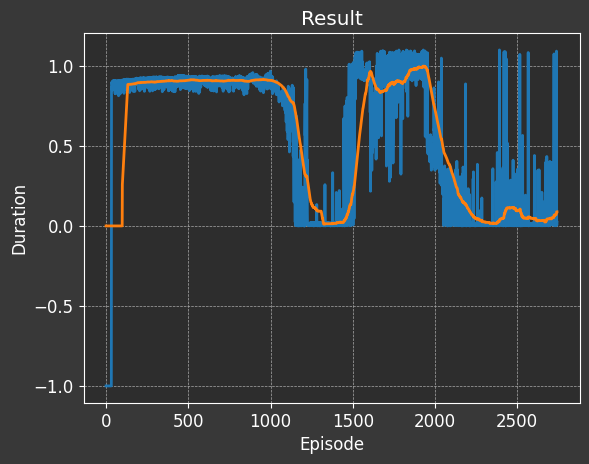

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [75]:
if torch.cuda.is_available():
    num_episodes = 1000
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    min_distance = 99
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        distance_to_goal = np.abs(0.5 - observation[0]) 
        reward = torch.tensor([reward], device=device)
        if distance_to_goal < min_distance:
            min_distance = distance_to_goal
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            # episode_durations.append(t + 1)
            rewards_list.append(min_distance)
            plot_rewards()
            break

print('Complete')
plot_rewards(show_result=True)
plt.ioff()
plt.show()

In [76]:
torch.save(policy_net, "data/models/mountain_car_policy_net.pt")
torch.save(target_net, "data/models/mountain_car_target_net.pt")

# Test Game

In [17]:
env.reset()

(array([-0.5452246,  0.       ], dtype=float32), {})

In [18]:
env.step(0)

(array([-0.5460625 , -0.00083792], dtype=float32), -1.0, False, False, {})

In [62]:
observation, reward, terminated, truncated, _ = env.step(0)

In [66]:
observation[0]

-0.40391475

In [65]:
-0.5 - observation[0] 


-0.09608525037765503

In [16]:
policy_net = torch.load("data/models/mountain_car_policy_net.pt")

In [25]:
import time

test_env = gym.make("CartPole-v1", render_mode="human")
state, info = test_env.reset()
time.sleep(2)
test_env.close()

In [40]:
state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

In [42]:
state_tensor

tensor([[-0.0372, -0.0021,  0.0095,  0.0339]], device='cuda:0')

In [43]:
state_tensor.unsqueeze(0).shape

torch.Size([1, 1, 4])

In [44]:
state_tensor.shape

torch.Size([1, 4])

In [45]:
policy_net_return_tensor = policy_net(state_tensor)
policy_net_return_tensor

tensor([[100.1264, 100.1853]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [51]:
action_tensor = policy_net_return_tensor.max(1).indices.view(1, 1)

In [52]:
action_tensor.item()

1

In [57]:
test_env = gym.make("CartPole-v1", render_mode="human")
state, info = test_env.reset()
for _ in range(100):
    test_env.step(action_tensor.item())
time.sleep(2)
test_env.close()

In [61]:
test_env = gym.make("CartPole-v1", render_mode="human")
state, info = test_env.reset()

done = False

while not done:
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action_tensor = policy_net(state_tensor).max(1).indices.view(1, 1)
    (state, reward, terminated, truncated, info) = test_env.step(action_tensor.item())
    if terminated or truncated:
        done = True

test_env.close()

array([0.04377633, 0.04221017, 0.01498252, 0.00650237], dtype=float32)

{}